<a href="https://colab.research.google.com/github/CastleJH/CastleMouse/blob/master/lesson6/lesson6_pets_more.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 6: pets revisited

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [0]:
#!pip install "torch==1.4" "torchvision==0.5.0"

그냥 하면 data = get_data(224, bs, 'zeros')에서 에러가 뜨므로 위 코드를 실행해준 후 런타임을 재시작한다.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


In [0]:
bs = 64

In [0]:
path = untar_data(URLs.PETS)/'images'

펫 이미지를 다운받는다.

## Data augmentation

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

transforms에 대해 더 자세히 알아볼 것이다. lesson1인가 2의 노트북에서도 언급했던 것 같지만, transform을 하면 이미지에 회전, 확대, 색조변경, 뒤틀림의 수준을 인자로 줄 수 있고, 인자로 준 확률만큼 적용된다(지금은 transform이 어떤 일을 하는지 보기 위해 무조건 적용되도록 확률을 1로 줬다).

In [7]:
doc(get_transforms)

독스에서 더 자세히 알아볼 수 있다.

In [0]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

그 후 실제로 transform을 적용하여 이미지를 보면,

In [0]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [0]:
data = get_data(224, bs, 'zeros')

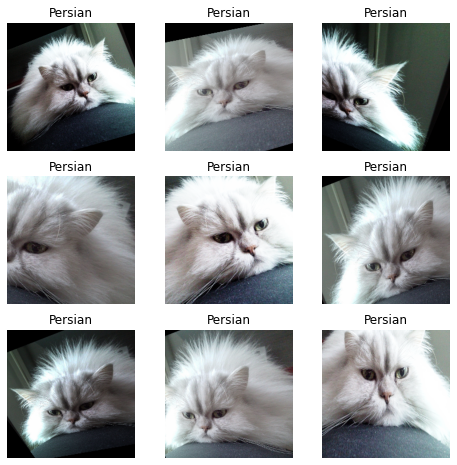

In [11]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

다음과 같이 같은 이미지에 다양한 변형이 적용된 것을 볼 수 있다. 이것이 바로 data augmentation로, 손쉽게 이미지의 풀을 넓혀줄 수 있다. 따라서 더 general하게 이미지를 받아들이게 되니, data augmentation을 적용하면 overfitting을 방지하는데에도 도움이 된다.

In [0]:
data = get_data(224,bs)

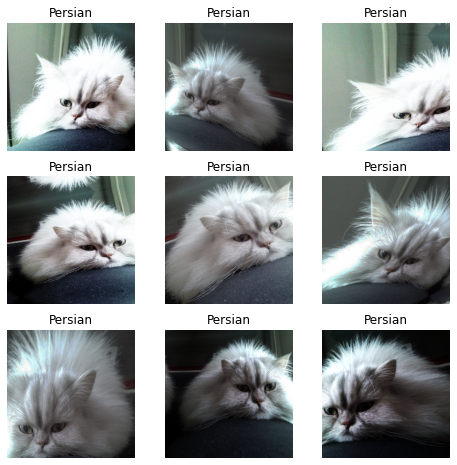

In [13]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

In [0]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

훈련시켜서 뒤에 쓸 것이다.

In [15]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,1.625813,0.357138,0.090663,01:53
1,0.971211,0.275664,0.081867,01:52
2,0.715959,0.245434,0.071719,01:52


In [16]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.604732,0.243634,0.064276,01:58
1,0.552238,0.223882,0.056157,01:57


In [0]:
data = get_data(352,bs)
learn.data = data

In [18]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.514313,0.199090,0.041949,03:36
1,0.471747,0.198185,0.041272,03:38


In [0]:
learn.save('352')

'352'라고 저장한다.

## Convolution kernel

In [0]:
data = get_data(352,16)

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

방금 훈련한 결과를 불러온다.

Category great_pyrenees

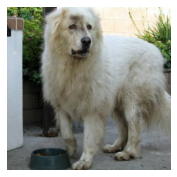

In [22]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

great pyrenees라는 종의 개이다.

In [0]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

여기서 kernel에 대해 배운다. 

일단 쉬운 설명을 위해 rgb값이 모두 동일한 흑백 사진이 있다고 한다. 그러면 각 픽셀과 그 픽셀을 둘러산 9개의 픽셀들에 대해 kernel을 곱해서 더해준다. 예를들어 kernel이 [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]이고 해당 픽셀과 둘러싼 픽셀들이 [[187, 217, 206], [82, 209, 238], [45, 167, 255]]였다면 kernel을 곱해서 더한 값은 193이므로 해당 픽셀은 193으로 변한다. 이렇게 하면, kenel의 모양에서 예측할 수 있듯 위아래로 극단적으로 값이 변해지는 지점(어두운 지점에서 밝은 지점, 또는 밝은 지점에서 어두운 지점)에서는 값이 서로 굉장히 달라지게 된다. 

rgb값이 서로 다른 컬러 사진이라면 어떨까? 컬러사진의 경우, 높이x넓이크기로 각 픽셀이 있으면 각 픽셀에 해당하는 rgb값이 있으므로 3차원의 input값이 들어올 것이다(width x height x rgb). 따라서 흑백의 2차원 kernel과 달리 각 rgb에 해당하는 채널을 가진 3차원의 kernel이 필요하다. 그래서 위의 k는 .expand로 복사(엄밀히 말하면 복사는 아니지만 어쨌든 같은 값으로 계산될 것임)되어 3차원의 kernel처럼 여겨지게 된다.
그런데 아래를 보면 k가 3차원이 아니라 4차원이다. 이것은 3차원인 kernel끼리 일렬로 쌓여있어서 하나를 이루게 된다고 이해하면 편하다.

이렇게 입력값에 kernel을 곱해줘서 출력하고, 출력된 값을 입력값으로 받아서 kernel을 곱해 출력하고... 이 과정을 반복하는 것이 지금껏 해온 cnn이다.

여기서 추가로 배울 것이 stride 2 convolution이다. stride 2 convolution이 하는 것은 딱 하나 차이가 있는데, 픽셀을 2씩 건너 뛰어 계산한다. 그렇기 때문에 input에 비해 output의 width와 height는 절반으로 줄어들고 채널은 2배씩 늘어날 것이다.

In [24]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [25]:
k.shape

torch.Size([1, 3, 3, 3])

In [26]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

In [27]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [0]:
edge = F.conv2d(t[None], k)

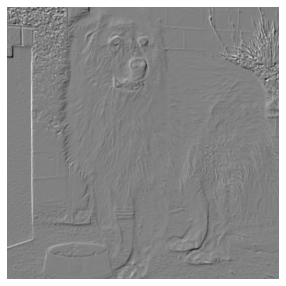

In [29]:
show_image(edge[0], figsize=(5,5));

In [30]:
data.c

37

In [31]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [32]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
___________________________________________________

입력은 352*352 픽셀의 이미지였다. stride 2 convolution에 의해 output을 보면 width height는 절반씩 줄어들고 채널은 2배로 늘어나는 모습을 볼 수 있다.

## Heatmap

In [0]:
m = learn.model.eval();

In [0]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

한개 데이터를 가진 mini batch를 만들어 gpu에 넘겨준다.

In [0]:
from fastai.callbacks.hooks import *

In [0]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

모델의 convolutional 부분에서 결과값을 가져온 후 이것을 forward pass를 해주고,

In [0]:
hook_a,hook_g = hooked_backward()

In [38]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

저장된 것을 가져와서 모양을 체크해주니 역시 위에서 최종적으로 나온 형태인 512 x 11 x 11이며,

In [39]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

11 x 11의 형태로 바꾸기 위해 채널들을 평균내주고,

In [0]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

이미지를 보여줄 때 위를 적용시키면서 히트맵으로 보여주니,

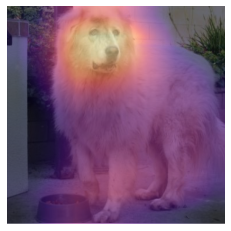

In [41]:
show_heatmap(avg_acts)

다음과 같이 구분하는데 중요한 요소였던 부분이 보여진다.

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [42]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [0]:
mult = (acts*grad_chan[...,None,None]).mean(0)

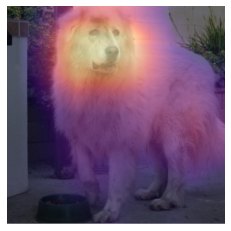

In [44]:
show_heatmap(mult)

In [0]:
fn = '/content/gdrive/My Drive/fastai-v3/Abyssinian.jpg' #Replace with your own image

Abyssinian 고양이이다.

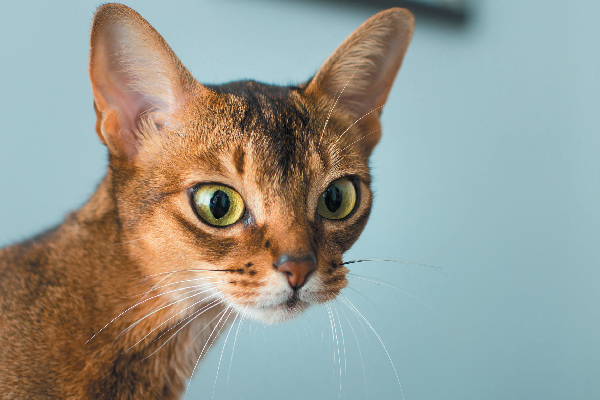

In [46]:
x = open_image(fn); x

In [0]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [0]:
hook_a,hook_g = hooked_backward()

In [0]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

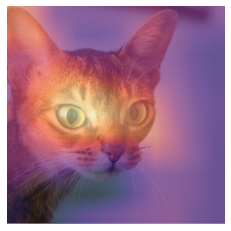

In [50]:
show_heatmap(mult)

In [51]:
data.classes[0]

'Abyssinian'

In [0]:
hook_a,hook_g = hooked_backward(0)

In [0]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

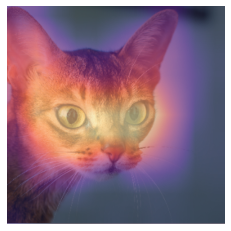

In [54]:
show_heatmap(mult)

## fin